# Modelling - PART 3
### Regression Model Selection and Testing 

Lasso Crossvalidation<br>
Ridge Crossvalidation<br>
Compare Regression Models<br>
Select best model<br>
Test model<br>

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import warnings; warnings.simplefilter('ignore')

%matplotlib inline
%pylab inline 
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'svg'
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

### 1. Read Data and Transform
Reading model data

In [3]:
df_model = pd.read_csv('../data/model_data.csv')
df_model = df_model.drop(columns="Unnamed: 0")

In [4]:
# transforming price with log 
df_model['price']=df_model['price'].apply(np.log)
df_model.head()

,price,year,mileage,drive_type,engine_size,num_cylinders,hp,comp_ratio,bore,stroke,values_per_cylinder,wheel_base,length,width,height,curb_weight,leg_room,head_room,seating_cap,cargo_cap,city_mpg,hw_mpg,luxury,black_interior,dark_exterior,light_exterior,prime_exterior,normal_engine,turbo_engine,alternate_engine
0,9.903388,2016,31000,2,2.4,4,201,12.0,3.43,3.90,4.0,105.1,181.9,70.0,55.0,2970,42.3,38.0,5,12.0,25,35,1,1,1,0,0,1,0,0
1,10.203518,2013,48000,4,3.0,6,272,10.0,3.33,3.50,0.0,110.5,182.6,74.0,65.0,4345,41.0,38.1,5,57.0,18,26,1,1,1,0,0,0,1,0
2,10.645377,2013,37000,4,4.2,8,450,13.0,3.33,3.65,0.0,108.3,183.0,73.0,53.0,3924,41.3,39.1,4,12.0,16,23,1,1,0,1,0,1,0,0
3,10.043163,2011,41000,4,2.0,4,265,9.8,3.25,3.65,4.0,97.2,165.3,72.0,53.0,3241,41.1,37.7,4,13.0,21,29,1,1,0,0,1,0,1,0
4,9.952182,2015,14000,4,2.0,4,180,11.0,3.31,3.55,4.0,110.6,182.1,71.0,56.0,3450,42.0,40.3,5,17.0,23,35,1,0,0,0,1,0,1,0


In [5]:
# considering only features that were found to be significant (p<0.05) when performing linear regression()
# refer to model_1.ipynb
p_significant = ['price','year', 'mileage','drive_type','engine_size',\
       'hp' , 'comp_ratio' , 
       'curb_weight'  , 'seating_cap' , \
       'city_mpg' , 'hw_mpg' , 'luxury' , 'dark_exterior' , \
       'light_exterior' , 'prime_exterior' , 'normal_engine' , 'turbo_engine' , 'alternate_engine']
df_model = df_model.loc [:,p_significant]
df_model.head()

,price,year,mileage,drive_type,engine_size,hp,comp_ratio,curb_weight,seating_cap,city_mpg,hw_mpg,luxury,dark_exterior,light_exterior,prime_exterior,normal_engine,turbo_engine,alternate_engine
0,9.903388,2016,31000,2,2.4,201,12.0,2970,5,25,35,1,1,0,0,1,0,0
1,10.203518,2013,48000,4,3.0,272,10.0,4345,5,18,26,1,1,0,0,0,1,0
2,10.645377,2013,37000,4,4.2,450,13.0,3924,4,16,23,1,0,1,0,1,0,0
3,10.043163,2011,41000,4,2.0,265,9.8,3241,4,21,29,1,0,0,1,0,1,0
4,9.952182,2015,14000,4,2.0,180,11.0,3450,5,23,35,1,0,0,1,0,1,0


### 2. Spliting model_data into train and test 

In [6]:
X=df_model.iloc[:,1:]
y=df_model['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=41)

### 3. Comparing Models 
Use lasso, ridge with cross validation <br>
Use only the train data for model comparision and selection

#### LASSO MODELS

In [8]:
# function for plotting mse_path_ for each degree 
# there are three paths as LassoCV and RidgeCV do 3 fold Cross validation
def plot_mse_path(ax,degree,alphas,mse):
    ax.semilogx(alphas,mse)
    ax.set_ylabel("MSE for CV (Test)")
    ax.set_xlabel("alpha")
    ax.set_title("Degree = "+ str(degree))

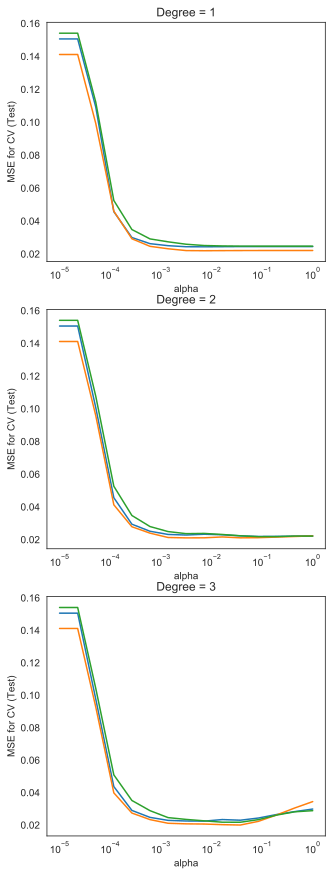

In [16]:
#Lasso Models
lasso_models =[] # list row sample - ['lasso',degree,alpha,MSE,R^2]
degrees = [1,2,3]
alphas = 10**np.linspace(-5,0,15)

fig, ax_rows = plt.subplots(3, 1, figsize=(5, 15))

# find optimal alpha using LassoCV

for degree,ax in zip(degrees,ax_rows):
    las = make_pipeline(PolynomialFeatures(degree, interaction_only=True),StandardScaler(),LassoCV(alphas=alphas))
    las.fit(X_train, y_train)
    alpha = las.get_params()['lassocv'].alpha_
    sse_tr_lasso = mean_squared_error(y_train, las.predict(X_train))
    r2_tr_lasso = las.score(X_train,y_train)
    plot_mse_path(ax,degree,alphas,las.get_params()['lassocv'].mse_path_)
    lasso_m = ['Lasso',degree,alpha,sse_tr_lasso,r2_tr_lasso]
    lasso_models.append(lasso_m)
    

Note: Looking at the MSE for Crossvalidation curves we can see that with degree 3 there is less stability. The variation between the 3 fold tests is higher - this indicates overfitting.   

In [17]:
print(lasso_models)

[['Lasso', 1, 0.0002682695795279727, 0.022715702870674915, 0.8466478465151291], ['Lasso', 2, 0.00011787686347935866, 0.01657242611365132, 0.8881206869333454], ['Lasso', 3, 0.0002682695795279727, 0.01459917603569045, 0.9014419629925661]]


#### RIDGE MODELS

In [18]:
#Ridge Models
ridge_models =[] # list row sample - ['ridge',degree,alpha,MSE,R^2]
degrees = [1,2,3]
alphas = 10**np.linspace(-5,0,10)


# find optimal alpha using RidgeCV
#ax_row in zip(alphas, ax_rows):
for degree in degrees:
    rid = make_pipeline(PolynomialFeatures(degree, interaction_only=True),StandardScaler(),RidgeCV(alphas=alphas))
    rid.fit(X_train, y_train)
    alpha = rid.get_params()['ridgecv'].alpha_
    sse_tr_ridge = mean_squared_error(y_train, rid.predict(X_train))
    r2_tr_ridge = rid.score(X_train,y_train)
    #plot_mse_path(ax,degree,alphas,rid.get_params()['ridgecv'].mse_path_)
    ridge_m = ['Ridge',degree,alpha,sse_tr_ridge,r2_tr_ridge]
    ridge_models.append(ridge_m)

In [19]:
print(ridge_models)

[['Ridge', 1, 1.0, 0.022673033964725652, 0.846935901375303], ['Ridge', 2, 1.0, 0.016368802419006092, 0.8894953365425683], ['Ridge', 3, 1.0, 0.011960095570903448, 0.9192582143671783]]


### 4. Model Selection

In [23]:
model_comp=pd.DataFrame(lasso_models,columns=['Type','Degree','Alpha','MSE-Train','R-sqr-Train'])
model_comp = model_comp.append(pd.DataFrame(ridge_models, \
                                            columns=['Type','Degree','Alpha','MSE-Train','R-sqr-Train']),ignore_index=True)
model_comp

,Type,Degree,Alpha,MSE-Train,R-sqr-Train
0,Lasso,1,0.000268,0.022716,0.846648
1,Lasso,2,0.000118,0.016572,0.888121
2,Lasso,3,0.000268,0.014599,0.901442
3,Ridge,1,1.000000,0.022673,0.846936
4,Ridge,2,1.000000,0.016369,0.889495
5,Ridge,3,1.000000,0.011960,0.919258


### Final Model - RIDGE , StandardScaler(), Polnomial Degree - 2

1. Both Lasso and Ridge have better results that Linear Regresssion
2. Using StandardScaler() since my features have very different ranges (eg. miles is in the thousands and hp is in the hundreds)
3. Looking at the mse paths for each of the models we see that the mse_path for degree 2 is better and that degree 3 may result in overfitting
4. Ridge with Degree -2 , StandardScaler() is the best model discuss
5. Looking at the models that we have generated ridge looks like it is fitting the training data better. Makes sense as features are correlated to each other.

### 5. Model Testing 

In [24]:
# Setup choosen model for Testing
# ridge,
f_alpha = 1

#Create model on train data
fmodel = make_pipeline(PolynomialFeatures(2, interaction_only=True),StandardScaler(),Ridge(alpha=f_alpha))
fmodel.fit(X_train, y_train)

# Use test data to find predicted and residual
test_pred=fmodel.predict(X_test)
residuals_test=y_test-test_pred


In [26]:
# calculates MSE, R-sqr
sse_te_ridge = mean_squared_error(y_test, fmodel.predict(X_test))
r2_te_ridge = fmodel.score(X_test,y_test)
print("MSE test", sse_te_ridge)
print("SCORE test",r2_te_ridge)

MSE test 0.01751672446858707
SCORE test 0.8761442668091045


float64


Text(0,0.5,'Actual Car Price (USD)')

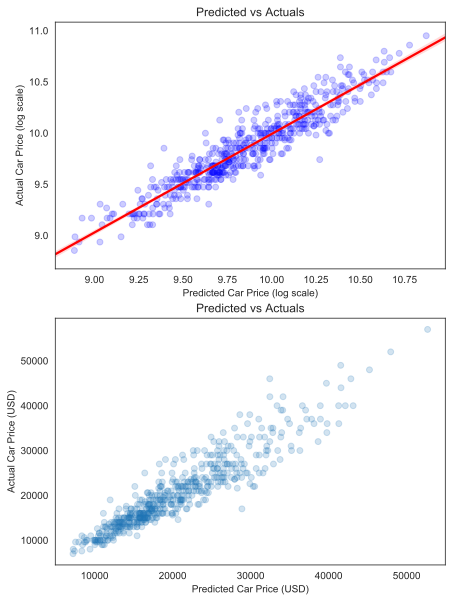

In [27]:
# make plots for y-actual vs y-predicted

fig= plt.figure(figsize=(7, 10))
ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,1,2)

#ax1.scatter(test_pred,y_test, alpha=0.2)
sns.regplot(test_pred,y_test ,scatter_kws={'color':'b','alpha':0.2},color='r', ax=ax1)
ax1.set_title("Predicted vs Actuals")
ax1.set_xlabel("Predicted Car Price (log scale)")
ax1.set_ylabel("Actual Car Price (log scale)")

print(test_pred.dtype)
ax2.scatter(np.exp(asarray(test_pred)), np.exp(asarray( y_test)), alpha=0.2)
ax2.set_title("Predicted vs Actuals")
ax2.set_xlabel("Predicted Car Price (USD)")
ax2.set_ylabel("Actual Car Price (USD)")

The model has a good fit for test data. It explains variance in the data

Text(0,0.5,'Residuals')

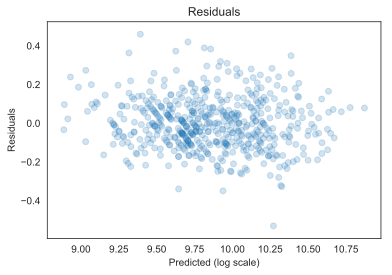

In [28]:
# plot residuals
plt.scatter(test_pred,residuals_test, alpha=0.2);
plt.title("Residuals")
plt.xlabel("Predicted (log scale)")
plt.ylabel("Residuals")

Residuals look normal - they don't show any specific pattern. 

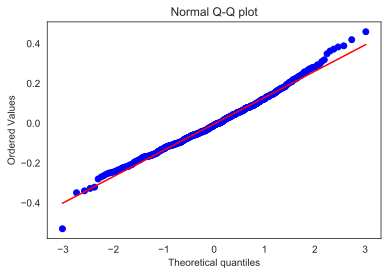

In [60]:
# make QQ Plot
stats.probplot(residuals_test, dist="norm", plot=plt);
plt.title("Normal Q-Q plot")
plt.show()

QQ plot looks good there is deviation at the either ends of the spectrum. This is because there are fewer data points at very high luxury level and very low level. This implies that our model is not as good at predicting in these regions.  

Text(0.5,1,'Distribution of residuals')

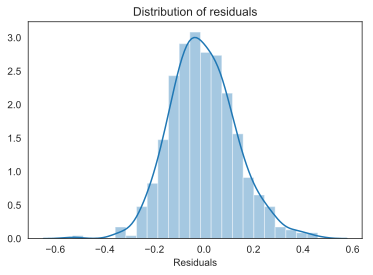

In [29]:
# make distribution pot of residuals
sns.distplot(residuals_test);
plt.xlabel("Residuals")
plt.title("Distribution of residuals")

Residuals are are normally distributed and centered around the mean of 0